In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import joblib
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [3]:
### LSTM
def reshape_data_for_lstm(x_train, x_test_scaled, x_val_scaled):
    x_train_array = x_train.values
    x_train_reshaped = np.expand_dims(x_train_array, axis=1)

    x_test_array = x_test_scaled.values
    x_test_reshaped = np.expand_dims(x_test_array, axis=1)

    x_val_array = x_val_scaled.values
    x_val_reshaped = np.expand_dims(x_val_array, axis=1)

    input_shape = (1, x_train_reshaped.shape[2]) #for LSTM
    return x_train_reshaped, x_test_reshaped, x_val_reshaped, input_shape



###cnn
def reshape_data_for_cnn(x_train, x_test_scaled, x_val_scaled):
    x_train_array = x_train.values
    x_train_reshaped = np.expand_dims(x_train_array, axis=-1)

    x_test_array = x_test_scaled.values
    x_test_reshaped = np.expand_dims(x_test_array, axis=-1)

    x_val_array = x_val_scaled.values
    x_val_reshaped = np.expand_dims(x_val_array, axis=-1)

    input_shape = (x_train_reshaped.shape[1],1) #cnn
    return x_train_reshaped, x_test_reshaped, x_val_reshaped, input_shape




In [27]:
def predDataForModelWithDaynight(mode, data_type = 'validation'):
    data = pd.read_csv('./merged_data.csv')

    data['daynight'] = data['daynight'].replace('D', 1)
    data['daynight'] = data['daynight'].replace('N', 0)
    target = data['type']

    if mode == 'daynight':
        dropped_data = data.drop(['longitude','latitude','acq_date','acq_time','satellite','instrument','type','confidence','version','precipitation_sum','frp'], axis=1)#,'daynight'
    else:
        dropped_data = data.drop(['longitude','latitude','acq_date','acq_time','satellite','instrument','type','daynight','confidence','version','precipitation_sum','frp','daynight'], axis=1)

    target.replace({0: 1, 1: 0, 2: 0,3:0},inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(dropped_data,target, test_size=0.2, random_state=42,stratify=target)
    x_train,x_val,y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42,stratify=y_train)

    # Load the saved scalers
    scalers = {}
    for column in x_train.columns:

        if column == 'daynight':
            continue
        scaler = joblib.load(f"{column}_scaler.pkl")
        scalers[column] = scaler

    # Transform the validation and test features using the loaded scalers
    x_val_scaled = x_val.copy()
    x_train_scaled = x_train.copy()
    x_test_scaled = x_test.copy()
    for column, scaler in scalers.items():
        x_train_scaled[[column]] = scaler.transform(x_train[[column]])
        x_val_scaled[[column]] = scaler.transform(x_val[[column]])
        x_test_scaled[[column]] = scaler.transform(x_test[[column]])
    


    x_train_reshaped, x_test_reshaped, x_val_reshaped, input_shape = reshape_data_for_cnn(x_train_scaled, x_test_scaled, x_val_scaled)
    x_train_reshaped_lstm, x_test_reshaped_lstm, x_val_reshaped_lstm, input_shape = reshape_data_for_lstm(x_train_scaled, x_test_scaled, x_val_scaled)

    if data_type=='training':
        return x_train_reshaped, x_train_reshaped_lstm, y_train, x_test_reshaped, x_test_reshaped_lstm, y_test
    

    return x_val_reshaped, x_val_reshaped_lstm, y_val

x_val_reshaped_daynight, x_val_reshaped_lstm_daynight, y_val = predDataForModelWithDaynight(mode='daynight')
x_val_reshaped, x_val_reshaped_lstm, y_val = predDataForModelWithDaynight(mode='')


In [2]:
model_cnn1 = load_model('models/cnn_1rst_88acc.h5')
model_cnn2 = load_model('models/cnn_daynight_89acc.h5')
model_lstm1 = load_model('models/lstm_model_89acc.h5')
model_lstm2 = load_model('models/lstm_daynight_90acc.h5')

In [6]:
#predict for cnn and plot roc
def create_roc_curve(model, data,title):
    if title.endswith('with daynight'):
        y_pred = model.predict(data.astype('float32')).ravel()
    else: 
        y_pred = model.predict(data).ravel()
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {title}')
    plt.legend(loc="lower right")
    plt.show()

138/138 [==============================] - 1s 4ms/step


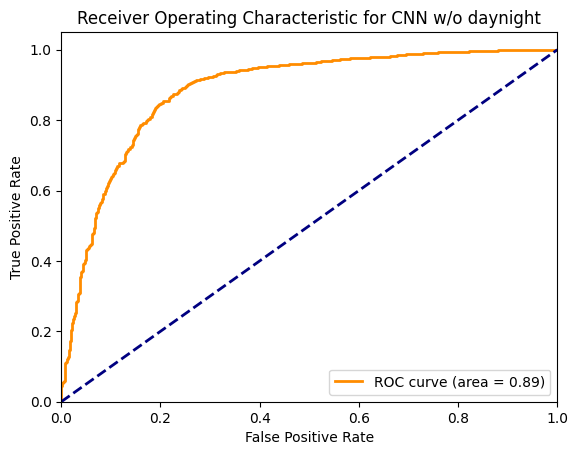

138/138 [==============================] - 1s 4ms/step


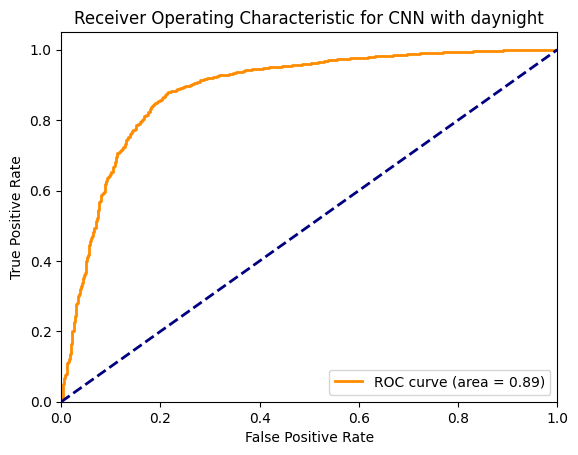

138/138 [==============================] - 3s 6ms/step


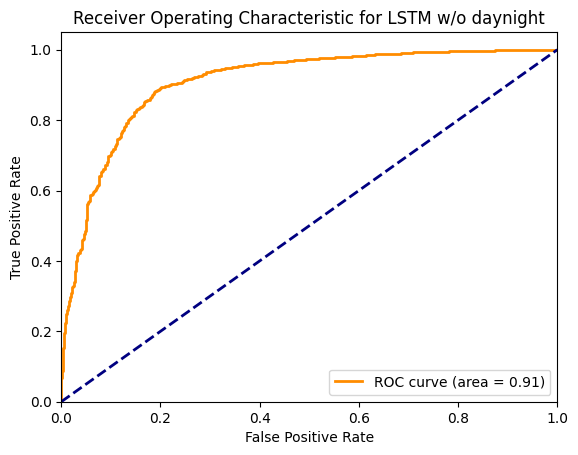

138/138 [==============================] - 4s 4ms/step


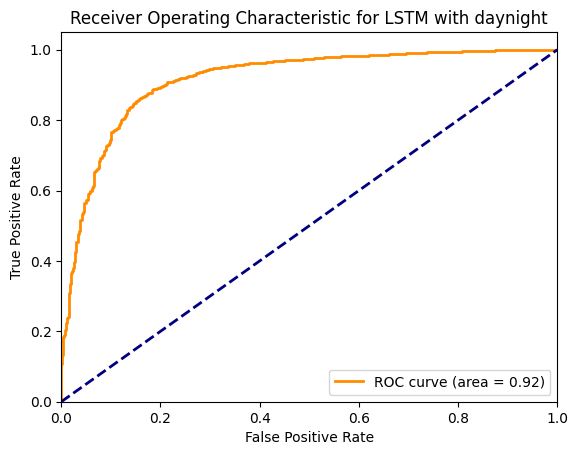

In [7]:
a1 = create_roc_curve(model_cnn1, x_val_reshaped,'CNN w/o daynight')
a2 = create_roc_curve(model_cnn2, x_val_reshaped_daynight,'CNN with daynight')
a3 =create_roc_curve(model_lstm1, x_val_reshaped_lstm,'LSTM w/o daynight')
a4 = create_roc_curve(model_lstm2, x_val_reshaped_lstm_daynight,'LSTM with daynight')


138/138 [==============================] - 1s 4ms/step


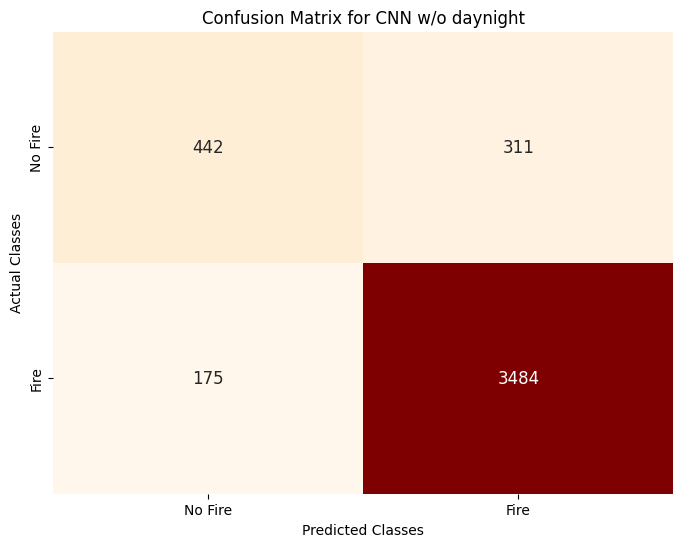

138/138 [==============================] - 1s 4ms/step


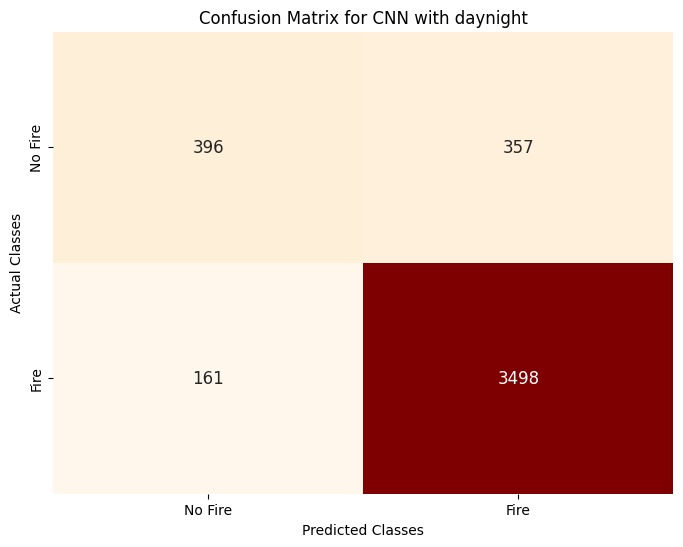

138/138 [==============================] - 1s 5ms/step


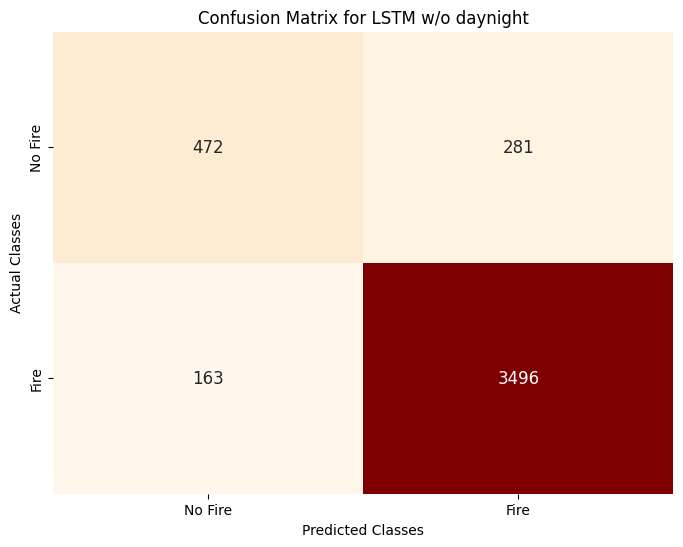

138/138 [==============================] - 1s 4ms/step


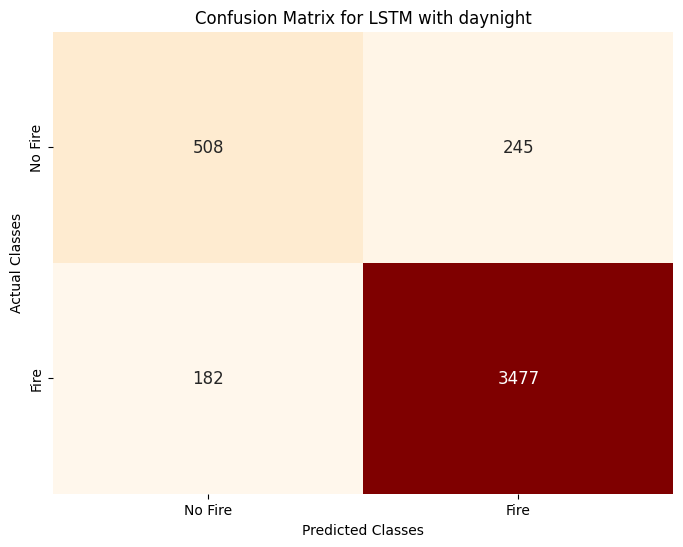

In [24]:
#create confusion matrices for each model create a function
def create_confusion_matrix(model, data,title):
    if title.endswith('with daynight'):
        y_pred = model.predict(data.astype('float32')).ravel()
    else: 
        y_pred = model.predict(data).ravel()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    # map 1 to Fire and 0 to No Fire
    #cm = confusion_matrix(y_val, y_pred)
    cm = pd.DataFrame(cm, index=['No Fire', 'Fire'], columns=['No Fire', 'Fire'])

    sns.heatmap(cm, annot=True, cmap='OrRd', fmt='g', annot_kws={"size": 12},cbar=False)
    plt.xlabel('Predicted Classes')
    plt.ylabel('Actual Classes')
    plt.title('Confusion Matrix for ' + title)
    plt.show()

b1 = create_confusion_matrix(model_cnn1, x_val_reshaped,'CNN w/o daynight')
b2 = create_confusion_matrix(model_cnn2, x_val_reshaped_daynight,'CNN with daynight')
b3 = create_confusion_matrix(model_lstm1, x_val_reshaped_lstm,'LSTM w/o daynight')
b4 = create_confusion_matrix(model_lstm2, x_val_reshaped_lstm_daynight,'LSTM with daynight')


In [36]:
#create classification report for each model create a function
def create_classification_report(model, data,title):
    if title.endswith('with daynight'):
        y_pred = model.predict(data.astype('float32')).ravel()
    else: 
        y_pred = model.predict(data).ravel()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print(classification_report(y_val, y_pred))

print('classification_report for CNN w/o daynight')
c1 = create_classification_report(model_cnn1, x_val_reshaped,'CNN w/o daynight')
print('classification_report for CNN with daynight')
c2 = create_classification_report(model_cnn2, x_val_reshaped_daynight,'CNN with daynight')
print('classification_report for LSTM w/o daynight')
c3 = create_classification_report(model_lstm1, x_val_reshaped_lstm,'LSTM w/o daynight')
print('classification_report for LSTM with daynight')
c4 = create_classification_report(model_lstm2, x_val_reshaped_lstm_daynight,'LSTM with daynight')

classification_report for CNN w/o daynight
138/138 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       753
           1       0.92      0.95      0.93      3659

    accuracy                           0.89      4412
   macro avg       0.82      0.77      0.79      4412
weighted avg       0.88      0.89      0.89      4412

classification_report for CNN with daynight
138/138 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.71      0.53      0.60       753
           1       0.91      0.96      0.93      3659

    accuracy                           0.88      4412
   macro avg       0.81      0.74      0.77      4412
weighted avg       0.87      0.88      0.88      4412

classification_report for LSTM w/o daynight
138/138 [==============================] - 1s 7ms/step
              precision    recall  f1-score   supp

In [7]:
y_pred_cnn1 = model_cnn1.predict(x_val_reshaped)
y_pred_cnn1 = np.where(y_pred_cnn1 > 0.5, 1, 0)

y_pred_cnn2 = model_cnn2.predict(x_val_reshaped_daynight.astype('float32'))
y_pred_cnn2 = np.where(y_pred_cnn2 > 0.5, 1, 0)

y_pred_lstm1 = model_lstm1.predict(x_val_reshaped_lstm)
y_pred_lstm1 = np.where(y_pred_lstm1 > 0.5, 1, 0)

y_pred_lstm2 = model_lstm2.predict(x_val_reshaped_lstm_daynight.astype('float32'))  
y_pred_lstm2 = np.where(y_pred_lstm2 > 0.5, 1, 0)

138/138 [==============================] - 3s 4ms/step


In [8]:
 
def vote(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

y_ens_pred = []
count = []
for i in range(len(y_pred_cnn1)):
    count.append(y_pred_cnn1[i])
    #count.append(y_pred_cnn2[i])
    count.append(y_pred_lstm1[i])
    count.append(y_pred_lstm2[i])
    y_ens_pred.append(vote(count))
    count = []

In [107]:
y_ens_pred = [x.astype('int') for x in y_ens_pred]
y_ens_pred

[array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),

In [19]:
from collections import Counter
from sklearn.metrics import classification_report
import numpy as np

def vote(List):
    if not List:
        return None
    counter = Counter(List)
    return counter.most_common(1)[0][0]

def average_vote(List):
    if not List:
        return None
    return np.mean(List)

y_ens_pred_average = []
y_ens_pred_majority = []
for i in range(len(y_pred_cnn1)):
    # Ensure that each prediction is a scalar value
    pred_cnn1 = y_pred_cnn1[i] if not isinstance(y_pred_cnn1[i], np.ndarray) else y_pred_cnn1[i].item()
    pred_lstm1 = y_pred_lstm1[i] if not isinstance(y_pred_lstm1[i], np.ndarray) else y_pred_lstm1[i].item()
    pred_lstm2 = y_pred_lstm2[i] if not isinstance(y_pred_lstm2[i], np.ndarray) else y_pred_lstm2[i].item()
    pred_cnn2 = y_pred_cnn2[i] if not isinstance(y_pred_cnn2[i], np.ndarray) else y_pred_cnn2[i].item()
    
    average_count = [
            pred_cnn1,
            pred_cnn2, 
            pred_lstm1, 
            pred_lstm2
        ]

    
    majority_count = [
            pred_cnn1,
            #pred_cnn2, 
            pred_lstm1, 
            pred_lstm2
        ]

    
    y_ens_pred_majority.append(vote(majority_count))
    y_ens_pred_average.append(average_vote(average_count))

# Ensure y_ens_pred is of the same type as y_val
y_ens_pred_average = [int(x) for x in y_ens_pred_average]
y_ens_pred_majority = [int(x) for x in y_ens_pred_majority]


print('classification_report for Ensemble with average vote')
print(classification_report(y_val, y_ens_pred_average))

print('classification_report for Ensemble with majority vote')
print(classification_report(y_val, y_ens_pred_majority))


classification_report for Ensemble with average vote
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       753
           1       0.94      0.93      0.94      3659

    accuracy                           0.90      4412
   macro avg       0.81      0.83      0.82      4412
weighted avg       0.90      0.90      0.90      4412

classification_report for Ensemble with majority vote
              precision    recall  f1-score   support

           0       0.75      0.65      0.69       753
           1       0.93      0.95      0.94      3659

    accuracy                           0.90      4412
   macro avg       0.84      0.80      0.82      4412
weighted avg       0.90      0.90      0.90      4412



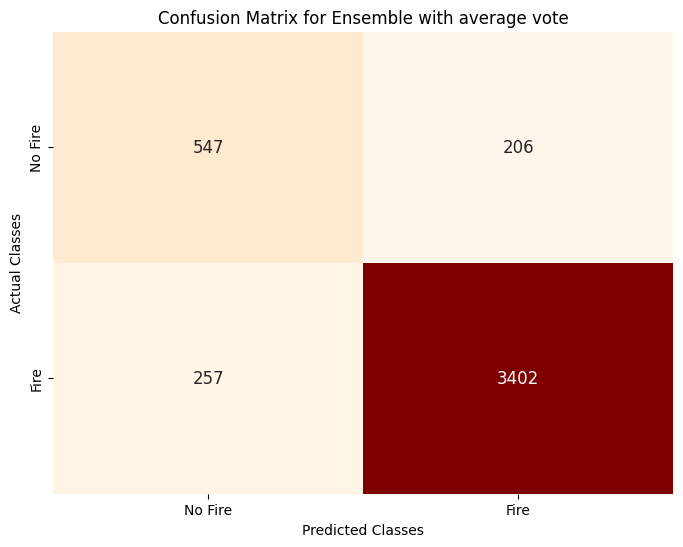

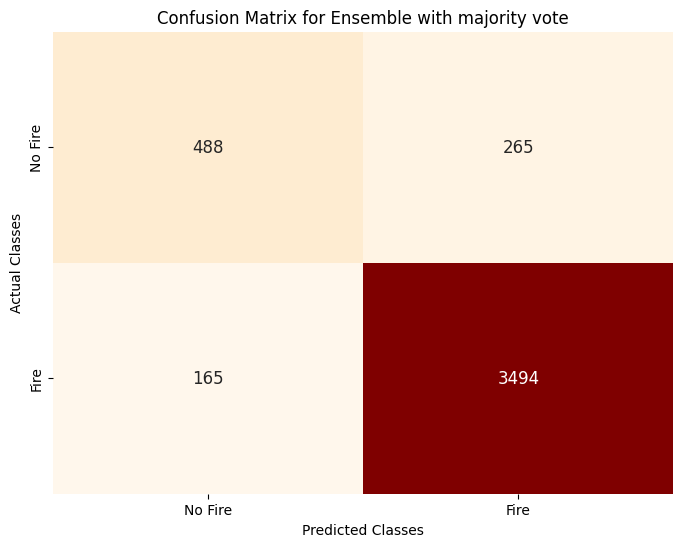

In [13]:
#create confusion matrices for ensemble models
def create_confusion_matrix_ensemble(y_pred,title):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    # map 1 to Fire and 0 to No Fire
    #cm = confusion_matrix(y_val, y_pred)
    cm = pd.DataFrame(cm, index=['No Fire', 'Fire'], columns=['No Fire', 'Fire'])

    sns.heatmap(cm, annot=True, cmap='OrRd', fmt='g', annot_kws={"size": 12},cbar=False)
    plt.xlabel('Predicted Classes')
    plt.ylabel('Actual Classes')
    plt.title('Confusion Matrix for ' + title)
    plt.show()


d1 = create_confusion_matrix_ensemble(y_ens_pred_average,'Ensemble with average vote')
d2 = create_confusion_matrix_ensemble(y_ens_pred_majority,'Ensemble with majority vote')


In [50]:
#model_cnn1.predict(x_test_reshaped)

# y_pred_test_cnn1 = model_cnn1.predict(x_test_reshaped)
# y_pred_test_cnn1 = np.where(y_pred_test_cnn1 > 0.5, 1, 0)

# y_pred_test_cnn2 = model_cnn2.predict(x_test_reshaped_daynight.astype('float32'))
# y_pred_test_cnn2 = np.where(y_pred_test_cnn2 > 0.5, 1, 0)

# y_pred_test_lstm1 = model_lstm1.predict(x_test_reshaped_lstm).ravel()
# y_pred_test_lstm1 = np.where(y_pred_test_lstm1 > 0.5, 1, 0)

# y_pred_test_lstm2 = model_lstm2.predict(x_test_reshaped_lstm_daynight.astype('float32')).ravel()
# y_pred_test_lstm2 = np.where(y_pred_test_lstm2 > 0.5, 1, 0)

y_pred_train_cnn1 = model_cnn1.predict(x_train_reshaped)
y_pred_train_cnn1 = np.where(y_pred_train_cnn1 > 0.5, 1, 0)

y_pred_train_cnn2 = model_cnn2.predict(x_train_reshaped_daynight.astype('float32'))
y_pred_train_cnn2 = np.where(y_pred_train_cnn2 > 0.5, 1, 0)

y_pred_train_lstm1 = model_lstm1.predict(x_train_reshaped_lstm).ravel()
y_pred_train_lstm1 = np.where(y_pred_train_lstm1 > 0.5, 1, 0)

y_pred_train_lstm2 = model_lstm2.predict(x_train_reshaped_lstm_daynight.astype('float32')).ravel()
y_pred_train_lstm2 = np.where(y_pred_train_lstm2 > 0.5, 1, 0)





552/552 [==============================] - 2s 4ms/step


In [51]:
print(classification_report(y_train, y_pred_train_cnn1))
print(classification_report(y_train, y_pred_train_cnn2))
print(classification_report(y_train, y_pred_train_lstm1))
print(classification_report(y_train, y_pred_train_lstm2))


              precision    recall  f1-score   support

           0       0.76      0.62      0.68      3013
           1       0.92      0.96      0.94     14635

    accuracy                           0.90     17648
   macro avg       0.84      0.79      0.81     17648
weighted avg       0.90      0.90      0.90     17648

              precision    recall  f1-score   support

           0       0.78      0.57      0.66      3013
           1       0.92      0.97      0.94     14635

    accuracy                           0.90     17648
   macro avg       0.85      0.77      0.80     17648
weighted avg       0.89      0.90      0.89     17648

              precision    recall  f1-score   support

           0       0.81      0.67      0.73      3013
           1       0.93      0.97      0.95     14635

    accuracy                           0.92     17648
   macro avg       0.87      0.82      0.84     17648
weighted avg       0.91      0.92      0.91     17648

              preci

In [47]:
#classification report for test data not the ensebmle
print(classification_report(y_pred_test_cnn1, y_test))
print(classification_report(y_pred_test_cnn2, y_test))
print(classification_report(y_pred_test_lstm1, y_test))
print(classification_report(y_pred_test_lstm2, y_test))


              precision    recall  f1-score   support

           0       0.62      0.75      0.68       781
           1       0.96      0.92      0.94      4735

    accuracy                           0.90      5516
   macro avg       0.79      0.84      0.81      5516
weighted avg       0.91      0.90      0.90      5516

              precision    recall  f1-score   support

           0       0.56      0.77      0.65       691
           1       0.97      0.92      0.94      4825

    accuracy                           0.90      5516
   macro avg       0.76      0.84      0.80      5516
weighted avg       0.92      0.90      0.90      5516

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       805
           1       0.96      0.93      0.95      4711

    accuracy                           0.91      5516
   macro avg       0.81      0.85      0.83      5516
weighted avg       0.92      0.91      0.91      5516

              preci

In [28]:
x_train_reshaped_daynight, x_train_reshaped_lstm_daynight, y_train, x_test_reshaped_daynight, x_test_reshaped_lstm_daynight, y_test = predDataForModelWithDaynight(mode='daynight',data_type='training')
x_train_reshaped, x_train_reshaped_lstm, y_train, x_test_reshaped, x_test_reshaped_lstm, y_test = predDataForModelWithDaynight(mode='',data_type='training')

Epoch 1/30
552/552 [==============================] - 34s 56ms/step - loss: 0.2981 - accuracy: 0.8817 - val_loss: 0.4083 - val_accuracy: 0.8287
Epoch 2/30
552/552 [==============================] - 37s 67ms/step - loss: 0.2852 - accuracy: 0.8905 - val_loss: 0.3413 - val_accuracy: 0.8550
Epoch 3/30
552/552 [==============================] - 37s 67ms/step - loss: 0.2811 - accuracy: 0.8927 - val_loss: 0.3064 - val_accuracy: 0.8869
Epoch 4/30
552/552 [==============================] - 36s 65ms/step - loss: 0.2782 - accuracy: 0.8917 - val_loss: 0.2878 - val_accuracy: 0.8836
Epoch 5/30
552/552 [==============================] - 35s 63ms/step - loss: 0.2789 - accuracy: 0.8937 - val_loss: 0.2743 - val_accuracy: 0.8934
Epoch 6/30
552/552 [==============================] - 35s 63ms/step - loss: 0.2757 - accuracy: 0.8956 - val_loss: 0.2731 - val_accuracy: 0.8952
Epoch 7/30
552/552 [==============================] - 34s 62ms/step - loss: 0.2742 - accuracy: 0.8955 - val_loss: 0.2796 - val_accuracy:

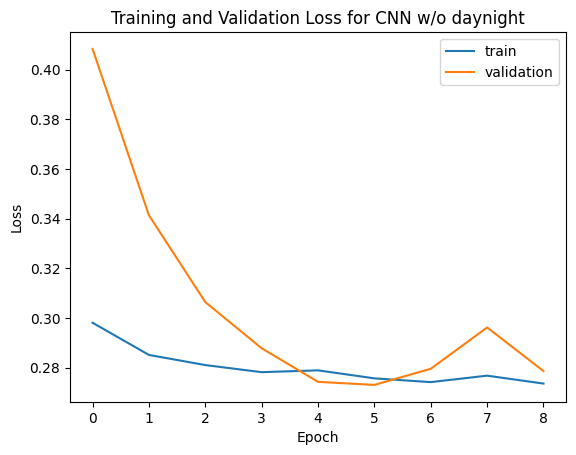

In [29]:
   
def create_model_training_loss_graph(model, training_data,test_data, title):
     # keep model architecture  get rid of weights retrain model
    model_json = model.to_json()

    # Step 2: Create a new model from the saved architecture
    new_model = tf.keras.models.model_from_json(model_json)

    # Step 3: Compile the model
    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    restore_best_weights=True
    )
    # Step 4: Train the model
    history = new_model.fit(training_data, y_train, epochs=30, batch_size=32,validation_data=(test_data, y_test),callbacks=[early_stopping])

    # Step 5: Plot the training and validation loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {title}')
    plt.legend()
    plt.show()


e1 = create_model_training_loss_graph(model_cnn1, x_train_reshaped,x_test_reshaped,'CNN w/o daynight')


In [31]:
e2 = create_model_training_loss_graph(model_cnn2, x_train_reshaped_daynight.astype('float32'),x_test_reshaped_daynight.astype('float32'),'CNN with daynight')

Epoch 1/30
552/552 [==============================] - 39s 65ms/step - loss: 0.3153 - accuracy: 0.8714 - val_loss: 0.3170 - val_accuracy: 0.8686
Epoch 2/30
552/552 [==============================] - 38s 69ms/step - loss: 0.2852 - accuracy: 0.8902 - val_loss: 0.2894 - val_accuracy: 0.8934
Epoch 3/30
 45/552 [=>............................] - ETA: 38s - loss: 0.2484 - accuracy: 0.9097

KeyboardInterrupt: 

In [32]:
e3 = create_model_training_loss_graph(model_lstm1, x_train_reshaped_lstm,x_test_reshaped_lstm,'LSTM w/o daynight')

Epoch 1/30
463/552 [========================>.....] - ETA: 2s - loss: 0.3190 - accuracy: 0.8696

KeyboardInterrupt: 